In [2]:
device = torch.device('cuda:' + str(hps.gpu))
writer = SummaryWriter()

if hps.dataset=='MNIST':
    base_model = models.LeNetMadry().to(device)
    train_loader = dl.MNIST_train_loader
    noise_loader = dl.Noise_train_loader_MNIST
elif hps.dataset=='CIFAR10':
    base_model = resnet.ResNet50().to(device).to(device)
    train_loader = dl.CIFAR10_train_loader
    noise_loader = dl.Noise_train_loader_CIFAR10
    
noise_loader = dl.PrecomputeLoader(noise_loader)

In [3]:

if hps.use_gmm:
    loading_string = hps.dataset+'_n'+str(hps.n) 
    gmm = torch.load('SavedModels/gmm_'+loading_string+'.pth')
    gmm.alpha = nn.Parameter(gmm.alpha)
    model = models.RobustModel(base_model, gmm, -5.).to(device)
    model.loglam.requires_grad = False
else:
    model = base_model

saving_string = hps.dataset+'_lam'+str(hps.lam)+'_n'+str(hps.n)



lr = .1*hps.lr

if hps.use_gmm:
    param_groups = [{'params':model.base_model.parameters(),'lr':lr, 'weight_decay':hps.decay},
                   {'params':model.mm.parameters(),'lr':lr, 'weight_decay':0.}]
else:
    param_groups = [{'params':model.parameters(),'lr':lr, 'weight_decay':hps.decay}]
    
optimizer = optim.Adam(param_groups)

In [465]:
gmm = torch.load('SavedModels/gmm_MNIST_n1000_data_used60000_scikit_data_augm.pth').to(device)

In [407]:
loader = dl.MNIST(train=True, augm_flag=False)
e = enumerate(loader)
for i in range(int(10*torch.rand(1))):
    data = e.__next__()[1][0]
data = e.__next__()[1][0]
#data = torch.rand(100,1,28,28)
torch.logsumexp( gmm(data.to(device).view(-1,784)), 0 ).min()

tensor(564.6626, device='cuda:0', grad_fn=<MinBackward1>)

In [466]:
with torch.no_grad():
    loader = dl.MNIST(train=True, augm_flag=False)
    X = []
    for x, f in loader:
        X.append(torch.logsumexp( gmm(data.to(device).view(-1,784)), 0 ))
    X = torch.cat(X, 0)

In [468]:
loglam = X.min()

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from importlib import reload

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import model_params as params
import resnet

from tensorboardX import SummaryWriter

In [29]:
base_model = models.LeNetMadry()

gmm = torch.load('SavedModels/gmm_MNIST_n1000_data_used60000_scikit_data_augm.pth').to(device)
gmm.alpha = nn.Parameter(gmm.alpha)
gmm.mu.requires_grad = True
gmm.logvar.requires_grad = True
gmm.alpha.requires_grad = False
loglam = 540.
model = models.RobustModel(base_model, gmm, loglam, dim=784).to(device)
model.loglam.requires_grad = False
writer = SummaryWriter()

In [31]:
train_loader = dl.MNIST(train=True, augm_flag=True)
noise_loader = dl.Noise(dataset='MNIST')
test_loader = dl.MNIST(train=False, augm_flag=False)

In [46]:
lr = 1e-3

param_groups = [{'params':model.mm.parameters(),'lr':lr, 'weight_decay':0.},
                {'params':model.base_model.parameters(),'lr':lr, 'weight_decay':5e-4}]

    
optimizer = optim.Adam(param_groups)


for epoch in range(10):
    if epoch+1 in [50,75,90]:
        for group in optimizer.param_groups:
            group['lr'] *= .1
    trainloss = tt.train_ACET(model, device, train_loader, 
                              noise_loader, 
                              optimizer, epoch, verbose=True)
    correct, ave_conf = tt.test(model, device, test_loader )
    writer.add_scalar('TestSet/TrainLoss', trainloss, epoch)
    writer.add_scalar('TestSet/Correct', correct, epoch)
    writer.add_scalar('TestSet/Confidence', ave_conf, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 4.605208


KeyboardInterrupt: 

In [9]:
device = torch.device('cuda:1')

In [53]:
loader = dl.SVHN(train=True, augm_flag=True)
e = enumerate(loader)
data = e.__next__()[1][0]
y = model(data.to(device))
y_base = model.base_model(data.to(device))
plotting.plot_samples([y,y_base], data, dataset='CIFAR10')

Using downloaded and verified file: ../data/train_32x32.mat


RuntimeError: shape '[100, 784]' is invalid for input of size 307200

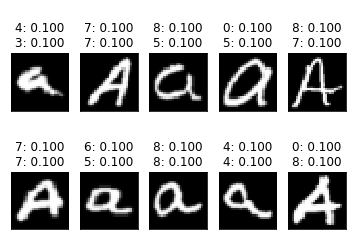

In [13]:
loader = dl.EMNIST(train=False, augm_flag=False)
e = enumerate(loader)
data = e.__next__()[1][0]
y = model(data.to(device))
y_base = model.base_model(data.to(device))
plotting.plot_samples([y, y_base], data)

In [499]:
(model.mm.logvar.exp()**.5).mean()

tensor(0.1937, device='cuda:2', grad_fn=<MeanBackward1>)

In [3]:
model = torch.load('SavedModels/gmm_model_MNIST_lam500.0_n1000 mu var alpha_customGMM.pth')

In [2]:
import torch

In [11]:
import utils.dataloaders as dl
import matplotlib.pyplot as plt
import utils.plotting as plotting

In [48]:
device = torch.device('cuda:2')
writer = SummaryWriter()

model_params = params.params_dict['MNIST'](augm_flag=True)
base_model = model_params.base_model

lam = 540


if True:
    loading_string = ('SavedModels/gmm_'+ 'MNIST'+'_n'+str(1000) +'.pth' 
                      if gmm_path is None else gmm_path)
    gmm = torch.load(loading_string) 
    
    gmm.alpha = nn.Parameter(gmm.alpha)
    gmm.mu.requires_grad = True
    gmm.logvar.requires_grad = True
    gmm.alpha.requires_grad = False
    model = models.RobustModel(base_model, gmm, lam, dim=model_params.dim).to(device)
    model.loglam.requires_grad = False
else:
    model = base_model.to(device)


lr = 5e-4
decay = 5e-4

if True:
    param_groups = [{'params':model.mm.parameters(),'lr':lr, 'weight_decay':0.},
                    {'params':model.base_model.parameters(),'lr':lr, 'weight_decay':decay}]
else:
    param_groups = [{'params':model.parameters(),'lr':lr, 'weight_decay':decay}]
    
optimizer = optim.Adam(param_groups)


for epoch in range(100):
    if epoch+1 in [50,75,90]:
        for group in optimizer.param_groups:
            group['lr'] *= .1
    trainloss = tt.train_ACET(model, device, model_params.train_loader, 
                              model_params.loaders[-1][1], 
                              optimizer, epoch, 
                              steps=40, verbose=True)
    
    correct, ave_conf = tt.test(model, device, model_params.test_loader )
    writer.add_scalar('TestSet/TrainLoss', trainloss, epoch)
    writer.add_scalar('TestSet/Correct', correct, epoch)
    writer.add_scalar('TestSet/Confidence', ave_conf, epoch)


Train Epoch: 0 [0/60000 (0%)]	Loss: 4.602342
Train Epoch: 0 [10000/60000 (17%)]	Loss: 4.605309
Train Epoch: 0 [20000/60000 (33%)]	Loss: 4.561818
Train Epoch: 0 [30000/60000 (50%)]	Loss: 4.381379
Train Epoch: 0 [40000/60000 (67%)]	Loss: 4.571195
Train Epoch: 0 [50000/60000 (83%)]	Loss: 4.146667
Train Epoch: 1 [0/60000 (0%)]	Loss: 4.586272
Train Epoch: 1 [10000/60000 (17%)]	Loss: 4.116273
Train Epoch: 1 [20000/60000 (33%)]	Loss: 3.939743
Train Epoch: 1 [30000/60000 (50%)]	Loss: 4.095060
Train Epoch: 1 [40000/60000 (67%)]	Loss: 4.033138
Train Epoch: 1 [50000/60000 (83%)]	Loss: 4.054797


KeyboardInterrupt: 

In [33]:
gmm_path = 'SavedModels/gmm_MNIST_n1000_data_used60000_scikit_data_augm.pth'

In [37]:
loading_string

'SavedModels/gmm_MNIST_n1000_data_used60000_scikit_data_augm.pth'

In [49]:
gmm_path = 'SavedModels/gmm_SVHN_n1000_data_used5000_scikit_data_augm.pth'

In [50]:
gmm = torch.load(gmm_path)

In [66]:
loader = dl.CIFAR10(train=True, augm_flag=False)
e = enumerate(loader)
data = e.__next__()[1][0]

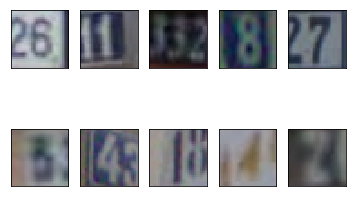

In [57]:
plotting.plot_samples([], data, dataset='CIFAR10')

In [65]:
torch.logsumexp(gmm(data.view(-1, 3072)), 0)

tensor([ 4320.7344,  4530.7466,  5757.0654,  5577.5317,  4997.3008,  5189.3989,
         5388.2485,  4985.5791,  5115.3262,  5610.0059,  5238.1572,  5961.1411,
         2232.0391,  5703.8857,  5139.5508,  6125.6416,  5697.5479,  1900.9175,
         4741.4502,  5306.0049,  5060.4619,  5373.1035,  6180.5479,  5828.1777,
         5776.9019,  5072.5586,  3034.3540,  5775.0654,  5684.7617, -1428.5845,
         3852.8894,  3138.3320,  3467.7268,  4627.3232,  4578.0386,  3235.6736,
         3844.7363,  5065.6123,  5812.5972,  5142.1904,  4905.3105,  3916.3413,
         4790.6528,  3969.3674,  4912.6064,  5247.2627,  4873.2539,  5969.2705,
         2382.6328,  5354.1406,  5370.4248,  5431.6040,  4865.1968,  5328.5713,
         2902.9097,  4104.1934,  4688.6646,  4438.3574,  3601.6672,  2083.8730,
         5660.6416,  5761.9497,  3660.8464,  5715.7080,  5942.8672,  3880.0952,
         5121.4302,  4790.1050,  4905.2798,  3859.3708,  4493.7568,  5815.6377,
         5235.2856,  4628.2412,  4966.56

In [70]:
torch.logsumexp(gmm(data.view(-1, 3072)), 0).std()

tensor(2267.5508, grad_fn=<StdBackward0>)

In [73]:
(gmm.logvar.exp()**.5).mean()

tensor(0.0550, grad_fn=<MeanBackward1>)

In [1]:
import torch
import numpy as np

In [6]:
a = torch.rand(5)
b = torch.rand(4)

array([0., 0., 0., 0., 0., 1., 1., 1., 1.], dtype=float32)